# Mentorship: Retention

This notebook digs into the effect access to a mentor has on retention. As we have seen in previous analyses, we expect it to also strongly correlate with activation. We'll investigate how estimates of retention vary based on asking your mentor a question or not.

In [17]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)

library(lme4)

library(here)

# R Configuration variables

In [49]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

# Configuration variables

In [3]:
## Path to the dataset with user information
user_dataset_filename <- here('datasets', 'mentorship_users.tsv')

## Column types in the user info dataset:
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers or doubles
user_dataset_column_types <- 'ficffiiflldd'

## Path to the dataset with Welcome Survey responses
survey_dataset_filename <- here('datasets', 'mentorship_survey_responses.tsv')

## Column types in the survey response dataset
survey_dataset_column_types <- 'fifffd'

## Path to the dataset with mentorship question edit data
mentor_edit_dataset_filename <- here('datasets', 'mentorship_edits.tsv')

## Column types in the mentorship question edit data
## We're skipping columns 8 & 9 because wiki_db and user_id are duplicated
mentor_edit_dataset_column_types <- 'ficffdd__iici'

## Wide dataset with editing data, used specifically for this type of analysis
editing_dataset_filename <- here('datasets', 'mentorship_editing_data.tsv')

## Column types in the editing dataset
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers
editing_dataset_column_types <- 'ficffddiiiiiiiiiiiiiiii'

# Data import and setup

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename, dataset_column_types) {
    read_tsv(
        dataset_filename,
        col_types = dataset_column_types) %>%
    mutate(
        # Parse the timestamp
        user_registration_ts = ymd_hms(user_registration),
        # Convert multiple variables to factors or boolean
        wiki_name = ifelse(wiki_db == 'eswiki', 'Spanish', 'English'),
        platform_name = ifelse(platform == 'desktop', 'Desktop', 'Mobile web'),
        has_mentor = ifelse(mentor_enabled == 1, TRUE, FALSE),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        num_total_edits_24hrs_no_mentor = num_total_edits_24hrs - num_mentorship_edits_24hrs,
        num_total_edits_2w_no_mentor = num_total_edits_2w - num_mentorship_edits_2w,
        num_total_edits_no_mentor = num_total_edits_24hrs_no_mentor + num_total_edits_2w_no_mentor,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Did they activate through mentorship?
        is_activated_mentor = num_mentorship_edits_24hrs > 0,
        # Did they activate for other reasons than asking their mentor?
        is_activated_no_mentor = num_total_edits_24hrs_no_mentor > 0,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
editing_data <- read_user_dataset(editing_dataset_filename, editing_dataset_column_types)

In [6]:
nrow(editing_data)

[1] 133832

In [20]:
survey_data <- read_tsv(survey_dataset_filename, col_types = survey_dataset_column_types)

In [21]:
editing_with_surveys <- editing_data |>
    inner_join(survey_data, by = c('wiki_db', 'user_id'))

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [ ]:
editing_data %>%
    group_by(wiki_db, platform, mentor_enabled) %>%
    summarize(n = n())

We filter out users with `mentor_enabled` set to 2 because they're so few of them. I suspect they disabled mentorship themselves.

In [8]:
editing_data <- editing_data |>
    filter(mentor_enabled < 2)

In [ ]:
editing_data |>
    group_by(wiki_db, platform, mentor_enabled) |>
    summarize(n = n()) |>
    mutate(per_group = sum(n)) |>
    mutate(perc = 100 * n / per_group)

In [10]:
editing_data |>
    group_by(wiki_db, mentor_enabled) |>
    tally() |>
    mutate(per_group = sum(n)) |>
    mutate(perc = 100 * n / per_group)

wiki_db mentor_enabled n      per_group perc
1 enwiki  0              101742 114512    88.8
2 enwiki  1               12770 114512    11.2
3 eswiki  0                9646  19305    50.0
4 eswiki  1                9659  19305    50.0

# Retention Proportions

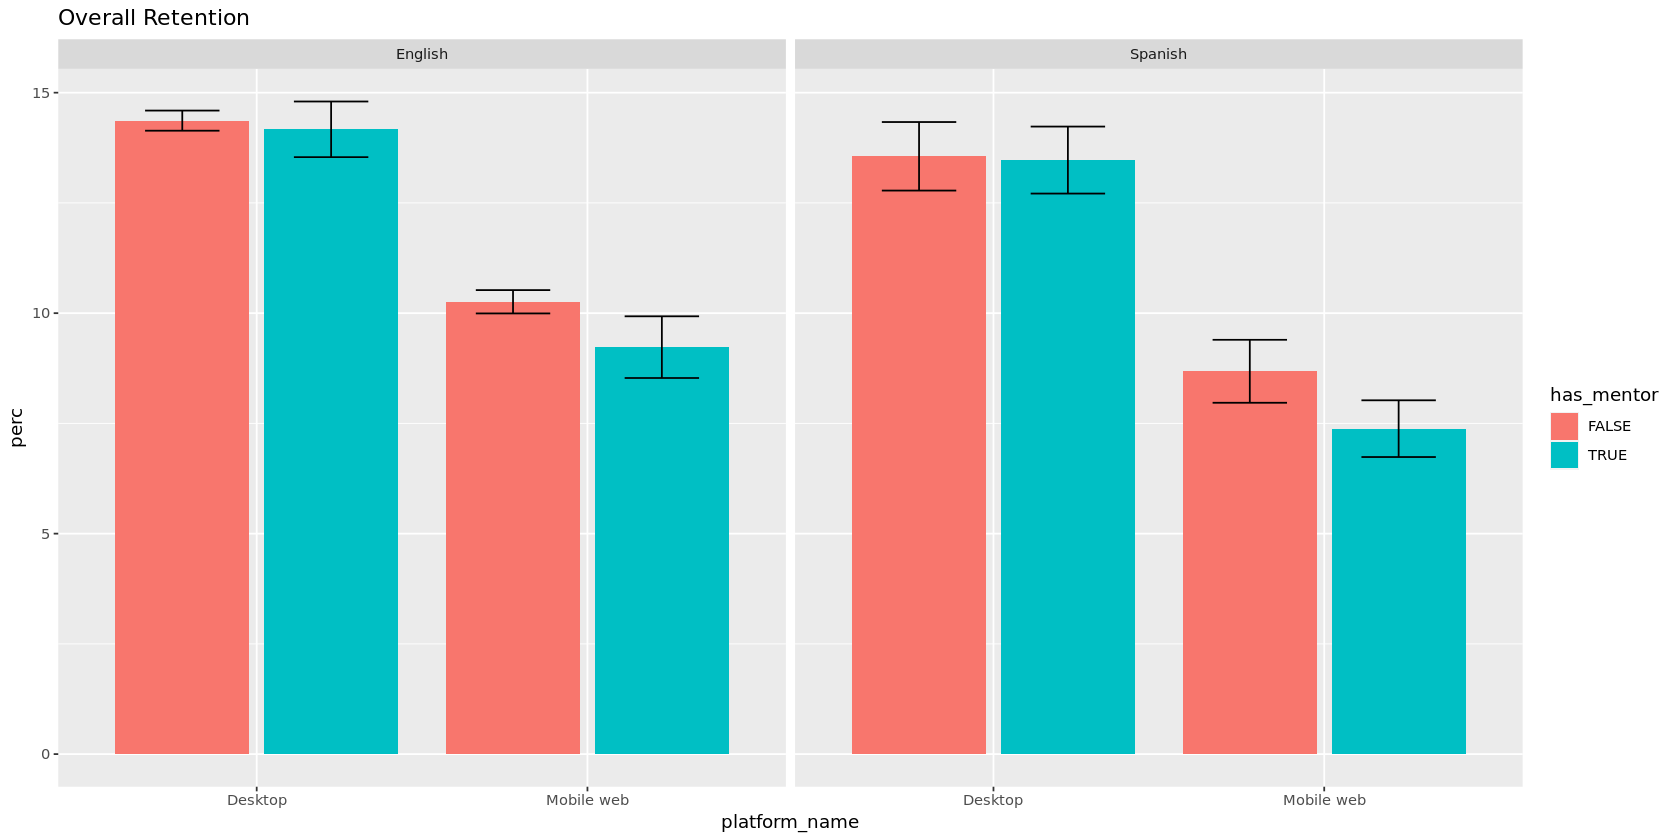

In [19]:
editing_data %>%
    filter(is_activated == TRUE) |>
    group_by(wiki_name, platform_name, has_mentor, is_retained) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_retained == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = has_mentor)) +
        labs(title = 'Overall Retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ wiki_name)

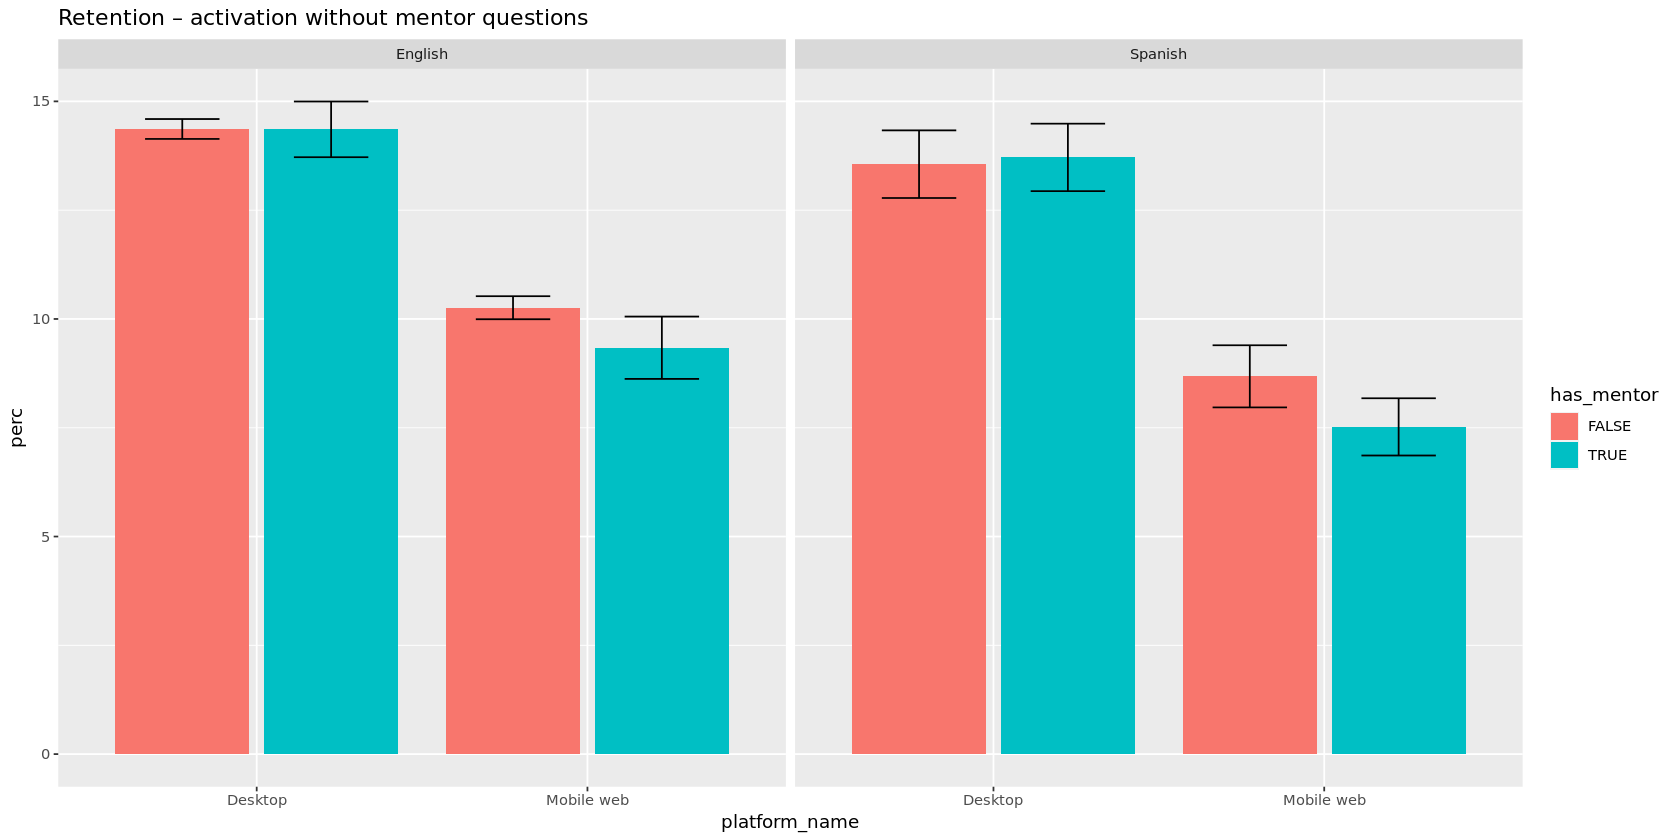

In [11]:
editing_data %>%
    filter(is_activated_no_mentor == TRUE) |>
    group_by(wiki_name, platform_name, has_mentor, is_retained) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_retained == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = has_mentor)) +
        labs(title = 'Retention – activation without mentor questions') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ wiki_name)

It looks like retention is lower in the group of users who registered on mobile web and have access to a mentor. Is that because they are looking to make an article and their mentor says "not a good idea"?

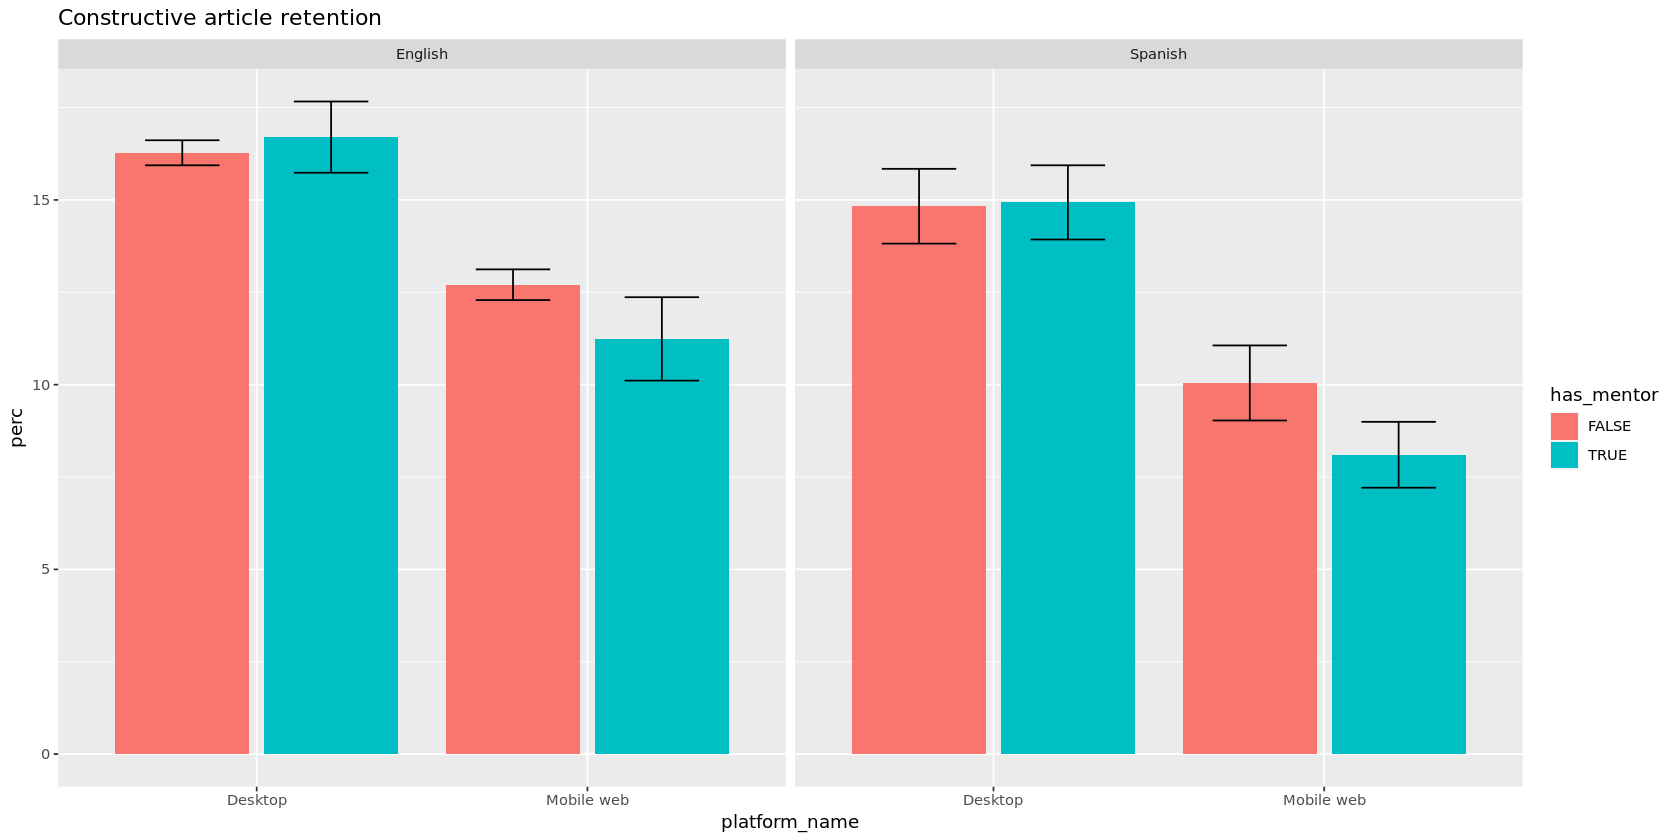

In [12]:
editing_data %>%
    filter(is_const_activated_article == TRUE) |>
    group_by(wiki_name, platform_name, has_mentor, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = has_mentor)) +
        labs(title = 'Constructive article retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ wiki_name)

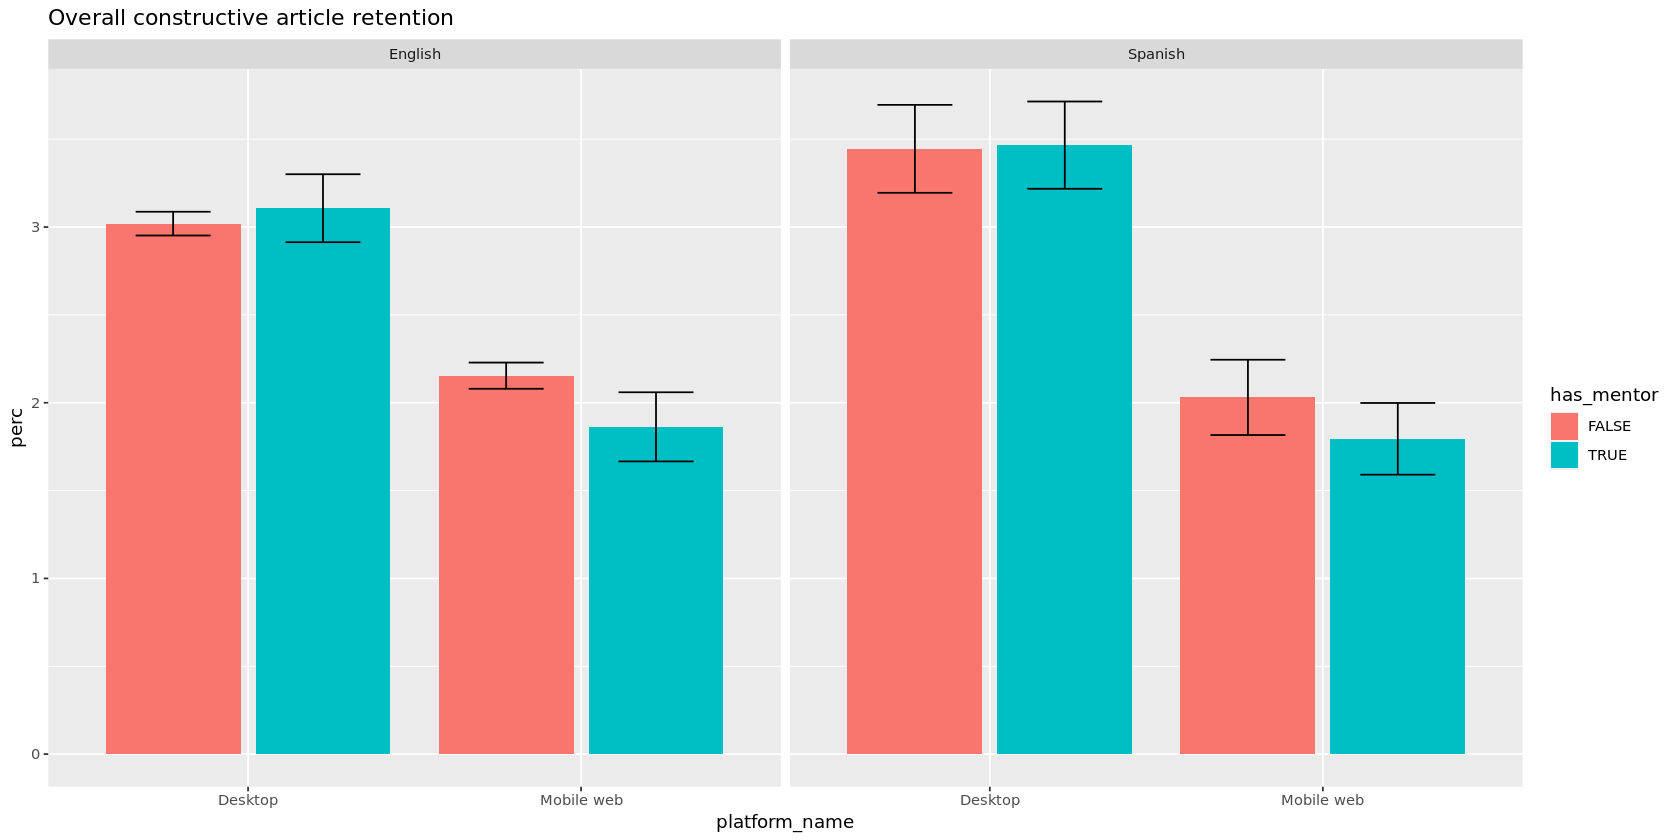

In [13]:
editing_data %>%
    group_by(wiki_name, platform_name, has_mentor, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = has_mentor)) +
        labs(title = 'Overall constructive article retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ wiki_name)

# Regression models

## Overall retention

### English

In [23]:
blas_set_num_threads(16)
enwiki.overall.retention.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_retained ~ platform + has_mentor + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [24]:
summary(enwiki.overall.retention.model.1)


Call:
glm(formula = is_retained ~ platform + has_mentor + is_activated + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(editing_with_surveys, 
    wiki_db == "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.908  -0.409   0.000   0.000   2.381  

Coefficients:
                    Estimate Std. Error z value            Pr(>|z|)    
(Intercept)         -21.7796   107.9673   -0.20                0.84    
platformdesktop       0.3357     0.0334   10.04 <0.0000000000000002 ***
has_mentorTRUE       -0.0442     0.0484   -0.91                0.36    
is_activatedTRUE     18.3383   107.9673    0.17                0.87    
log_num_edits_24hrs   1.0249     0.0216   47.38 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 43039  on 114511  degrees of freedom
Residual deviance: 29383  on 114507  degrees of freedom
AIC: 29393

N

In [25]:
blas_set_num_threads(16)
enwiki.overall.retention.model.2 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_retained ~ platform * has_mentor + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [26]:
summary(enwiki.overall.retention.model.2)


Call:
glm(formula = is_retained ~ platform * has_mentor + is_activated + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(editing_with_surveys, 
    wiki_db == "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.907  -0.409   0.000   0.000   2.413  

Coefficients:
                               Estimate Std. Error z value            Pr(>|z|)
(Intercept)                    -21.7699   107.9656   -0.20                0.84
platformdesktop                  0.3218     0.0354    9.09 <0.0000000000000002
has_mentorTRUE                  -0.1332     0.0910   -1.46                0.14
is_activatedTRUE                18.3381   107.9656    0.17                0.87
log_num_edits_24hrs              1.0250     0.0216   47.39 <0.0000000000000002
platformdesktop:has_mentorTRUE   0.1253     0.1075    1.17                0.24
                                  
(Intercept)                       
platformdesktop                ***
has_mentorTRUE           

In [27]:
blas_set_num_threads(16)
enwiki.overall.retention.model.3 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_retained ~ platform + has_mentor + log_num_edits_24hrs,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(enwiki.overall.retention.model.3)

In [30]:
blas_set_num_threads(16)
enwiki.overall.retention.model.4 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_retained ~ platform * log_num_edits_24hrs + has_mentor + is_activated,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [31]:
summary(enwiki.overall.retention.model.4)


Call:
glm(formula = is_retained ~ platform * log_num_edits_24hrs + 
    has_mentor + is_activated, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.966  -0.415   0.000   0.000   2.426  

Coefficients:
                                    Estimate Std. Error z value
(Intercept)                         -22.0068   107.5774   -0.20
platformdesktop                       0.6573     0.0743    8.85
log_num_edits_24hrs                   1.1866     0.0397   29.90
has_mentorTRUE                       -0.0455     0.0484   -0.94
is_activatedTRUE                     18.3414   107.5774    0.17
platformdesktop:log_num_edits_24hrs  -0.2314     0.0473   -4.89
                                                Pr(>|z|)    
(Intercept)                                         0.84    
platformdesktop                     < 0.0000000000000002 ***
log_num_edits_24hrs                 < 0.000000000000

In [32]:
blas_set_num_threads(16)
enwiki.overall.retention.model.5 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_retained ~ platform * log_num_edits_24hrs * has_mentor + is_activated,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(enwiki.overall.retention.model.5)

In [34]:
blas_set_num_threads(16)
enwiki.overall.retention.model.6 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_retained ~ platform * log_num_edits_24hrs + has_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(enwiki.overall.retention.model.6)

*Conclusion:* Model 4 is the one with the best fitness. We see no significant difference in retention from having a mentor. We also see that when comparing desktop and mobile web registrations, the latter see a stronger effect of activity on retention. This is not a causal relationship, instead it might be that those who are capable of editing on mobile web are already dedicated and therefore stick around at higher rates than those on desktop.

## Spanish

In [36]:
blas_set_num_threads(16)
eswiki.overall.retention.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_retained ~ platform + has_mentor + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [37]:
summary(eswiki.overall.retention.model.1)


Call:
glm(formula = is_retained ~ platform + has_mentor + is_activated + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(editing_with_surveys, 
    wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.864  -0.316   0.000   0.000   2.484  

Coefficients:
                    Estimate Std. Error z value             Pr(>|z|)    
(Intercept)         -21.9031   263.9406   -0.08                 0.93    
platformdesktop       0.6009     0.0827    7.27     0.00000000000037 ***
has_mentorTRUE       -0.0632     0.0782   -0.81                 0.42    
is_activatedTRUE     18.2817   263.9406    0.07                 0.94    
log_num_edits_24hrs   0.9319     0.0504   18.48 < 0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6609.6  on 19304  degrees of freedom
Residual deviance: 4595.2  on 19300  degrees of freedom
AIC: 46

In [38]:
blas_set_num_threads(16)
eswiki.overall.retention.model.2 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_retained ~ platform * log_num_edits_24hrs + has_mentor + is_activated,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [39]:
summary(eswiki.overall.retention.model.2)


Call:
glm(formula = is_retained ~ platform * log_num_edits_24hrs + 
    has_mentor + is_activated, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.790  -0.307   0.000   0.000   2.505  

Coefficients:
                                    Estimate Std. Error z value
(Intercept)                         -22.0206   263.2506   -0.08
platformdesktop                       0.7713     0.1708    4.52
log_num_edits_24hrs                   1.0027     0.0801   12.52
has_mentorTRUE                       -0.0612     0.0782   -0.78
is_activatedTRUE                     18.2937   263.2506    0.07
platformdesktop:log_num_edits_24hrs  -0.1181     0.1032   -1.14
                                                Pr(>|z|)    
(Intercept)                                         0.93    
platformdesktop                                0.0000063 ***
log_num_edits_24hrs                 < 0.000000000000

We do not find an interaction in Spanish as we saw in English.

In [40]:
blas_set_num_threads(16)
eswiki.overall.retention.model.3 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_retained ~ platform * log_num_edits_24hrs * has_mentor + is_activated,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(eswiki.overall.retention.model.3)

In [42]:
blas_set_num_threads(16)
eswiki.overall.retention.model.4 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_retained ~ platform * has_mentor + is_activated + log_num_edits_24hrs,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [43]:
summary(eswiki.overall.retention.model.4)


Call:
glm(formula = is_retained ~ platform * has_mentor + is_activated + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(editing_with_surveys, 
    wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.853  -0.323   0.000   0.000   2.502  

Coefficients:
                               Estimate Std. Error z value             Pr(>|z|)
(Intercept)                    -21.8590   263.9363   -0.08                 0.93
platformdesktop                  0.5327     0.1161    4.59            0.0000044
has_mentorTRUE                  -0.1540     0.1345   -1.14                 0.25
is_activatedTRUE                18.2836   263.9363    0.07                 0.94
log_num_edits_24hrs              0.9311     0.0504   18.46 < 0.0000000000000002
platformdesktop:has_mentorTRUE   0.1372     0.1654    0.83                 0.41
                                  
(Intercept)                       
platformdesktop                ***
has_mentorTRUE    

In [44]:
blas_set_num_threads(16)
eswiki.overall.retention.model.5 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_retained ~ platform * has_mentor + log_num_edits_24hrs,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(eswiki.overall.retention.model.5)

*Conclusion:* Model 1 shows that there is no significant difference in retention rates in spanish.

## Overall without mentor edits

In [60]:
blas_set_num_threads(16)
enwiki.overall_no_mentor.retention.model.1 <- editing_with_surveys |>
    mutate(
        log_num_edits_24hrs_no_mentor = log(1 + num_total_edits_24hrs_no_mentor),
        is_retained_no_mentor = ifelse(is_activated_no_mentor & num_total_edits_2w_no_mentor > 0, TRUE, FALSE)
    ) |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_retained_no_mentor ~ platform + has_mentor + is_activated_no_mentor + log_num_edits_24hrs_no_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [61]:
summary(enwiki.overall_no_mentor.retention.model.1)


Call:
glm(formula = is_retained_no_mentor ~ platform + has_mentor + 
    is_activated_no_mentor + log_num_edits_24hrs_no_mentor, family = binomial(link = "logit"), 
    data = filter(mutate(editing_with_surveys, log_num_edits_24hrs_no_mentor = log(1 + 
        num_total_edits_24hrs_no_mentor), is_retained_no_mentor = ifelse(is_activated_no_mentor & 
        num_total_edits_2w_no_mentor > 0, TRUE, FALSE)), wiki_db == 
        "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.906  -0.411   0.000   0.000   2.376  

Coefficients:
                              Estimate Std. Error z value            Pr(>|z|)
(Intercept)                   -21.7810   107.8811   -0.20                0.84
platformdesktop                 0.3361     0.0335   10.05 <0.0000000000000002
has_mentorTRUE                 -0.0325     0.0486   -0.67                0.50
is_activated_no_mentorTRUE     18.3419   107.8811    0.17                0.86
log_num_edits_24hrs_no_mentor   1.0230     0.0216 

In [62]:
blas_set_num_threads(16)
enwiki.overall_no_mentor.retention.model.2 <- editing_with_surveys |>
    mutate(
        log_num_edits_24hrs_no_mentor = log(1 + num_total_edits_24hrs_no_mentor),
        is_retained_no_mentor = ifelse(is_activated_no_mentor & num_total_edits_2w_no_mentor > 0, TRUE, FALSE)
    ) |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_retained_no_mentor ~ platform * log_num_edits_24hrs_no_mentor + has_mentor + is_activated_no_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [63]:
summary(enwiki.overall_no_mentor.retention.model.2)


Call:
glm(formula = is_retained_no_mentor ~ platform * log_num_edits_24hrs_no_mentor + 
    has_mentor + is_activated_no_mentor, family = binomial(link = "logit"), 
    data = filter(mutate(editing_with_surveys, log_num_edits_24hrs_no_mentor = log(1 + 
        num_total_edits_24hrs_no_mentor), is_retained_no_mentor = ifelse(is_activated_no_mentor & 
        num_total_edits_2w_no_mentor > 0, TRUE, FALSE)), wiki_db == 
        "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.964  -0.418   0.000   0.000   2.421  

Coefficients:
                                              Estimate Std. Error z value
(Intercept)                                   -22.0089   107.4897   -0.20
platformdesktop                                 0.6588     0.0743    8.86
log_num_edits_24hrs_no_mentor                   1.1854     0.0397   29.84
has_mentorTRUE                                 -0.0339     0.0486   -0.70
is_activated_no_mentorTRUE                     18.3449   107.4897    0

We find the same interaction between `platform` and number of edits made as we saw before.

In [64]:
blas_set_num_threads(16)
enwiki.overall_no_mentor.retention.model.3 <- editing_with_surveys |>
    mutate(
        log_num_edits_24hrs_no_mentor = log(1 + num_total_edits_24hrs_no_mentor),
        is_retained_no_mentor = ifelse(is_activated_no_mentor & num_total_edits_2w_no_mentor > 0, TRUE, FALSE)
    ) |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_retained_no_mentor ~ platform * log_num_edits_24hrs_no_mentor * has_mentor + is_activated_no_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(enwiki.overall_no_mentor.retention.model.3)

We find no evidence of an additional interaction and keep Model 2.

*Conclusion:* There's no difference in likelihood of retention.

### Spanish

In [72]:
blas_set_num_threads(16)
eswiki.overall_no_mentor.retention.model.1 <- editing_with_surveys |>
    mutate(
        log_num_edits_24hrs_no_mentor = log(1 + num_total_edits_24hrs_no_mentor),
        is_retained_no_mentor = ifelse(is_activated_no_mentor & num_total_edits_2w_no_mentor > 0, TRUE, FALSE)
    ) |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_retained_no_mentor ~ platform + has_mentor + is_activated_no_mentor + log_num_edits_24hrs_no_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [73]:
summary(eswiki.overall_no_mentor.retention.model.1)


Call:
glm(formula = is_retained_no_mentor ~ platform + has_mentor + 
    is_activated_no_mentor + log_num_edits_24hrs_no_mentor, family = binomial(link = "logit"), 
    data = filter(mutate(editing_with_surveys, log_num_edits_24hrs_no_mentor = log(1 + 
        num_total_edits_24hrs_no_mentor), is_retained_no_mentor = ifelse(is_activated_no_mentor & 
        num_total_edits_2w_no_mentor > 0, TRUE, FALSE)), wiki_db == 
        "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.854  -0.316   0.000   0.000   2.478  

Coefficients:
                              Estimate Std. Error z value             Pr(>|z|)
(Intercept)                   -21.9089   262.9262   -0.08                 0.93
platformdesktop                 0.6019     0.0830    7.25     0.00000000000041
has_mentorTRUE                 -0.0519     0.0784   -0.66                 0.51
is_activated_no_mentorTRUE     18.2959   262.9262    0.07                 0.94
log_num_edits_24hrs_no_mentor   0.9255     0.

In [70]:
blas_set_num_threads(16)
eswiki.overall_no_mentor.retention.model.2 <- editing_with_surveys |>
    mutate(
        log_num_edits_24hrs_no_mentor = log(1 + num_total_edits_24hrs_no_mentor),
        is_retained_no_mentor = ifelse(is_activated_no_mentor & num_total_edits_2w_no_mentor > 0, TRUE, FALSE)
    ) |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_retained_no_mentor ~ platform * log_num_edits_24hrs_no_mentor + has_mentor + is_activated_no_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [71]:
summary(eswiki.overall_no_mentor.retention.model.2)


Call:
glm(formula = is_retained_no_mentor ~ platform * log_num_edits_24hrs_no_mentor + 
    has_mentor + is_activated_no_mentor, family = binomial(link = "logit"), 
    data = filter(mutate(editing_with_surveys, log_num_edits_24hrs_no_mentor = log(1 + 
        num_total_edits_24hrs_no_mentor), is_retained_no_mentor = ifelse(is_activated_no_mentor & 
        num_total_edits_2w_no_mentor > 0, TRUE, FALSE)), wiki_db == 
        "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.777  -0.307   0.000   0.000   2.500  

Coefficients:
                                              Estimate Std. Error z value
(Intercept)                                   -22.0308   262.2099   -0.08
platformdesktop                                 0.7784     0.1714    4.54
log_num_edits_24hrs_no_mentor                   0.9988     0.0803   12.44
has_mentorTRUE                                 -0.0498     0.0784   -0.64
is_activated_no_mentorTRUE                     18.3086   262.2099    0

We again do not find the interaction we see in English. Gosh, these per-wiki difference are fascinating!

In [74]:
blas_set_num_threads(16)
eswiki.overall_no_mentor.retention.model.3 <- editing_with_surveys |>
    mutate(
        log_num_edits_24hrs_no_mentor = log(1 + num_total_edits_24hrs_no_mentor),
        is_retained_no_mentor = ifelse(is_activated_no_mentor & num_total_edits_2w_no_mentor > 0, TRUE, FALSE)
    ) |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_retained_no_mentor ~ platform * has_mentor + log_num_edits_24hrs_no_mentor + is_activated_no_mentor,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(eswiki.overall_no_mentor.retention.model.3)

*Conclusion:* We see no significant difference in retention between those who have access to a mentor and those who do not, when keeping first-day activity constant.

## Constructive article retention

### English

In [76]:
blas_set_num_threads(16)
enwiki.constr_article.retention.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_const_retained_article ~ platform + has_mentor +
                    is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [77]:
summary(enwiki.constr_article.retention.model.1)


Call:
glm(formula = is_const_retained_article ~ platform + has_mentor + 
    is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_with_surveys, 
        wiki_db == "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -2.04    0.00    0.00    0.00    2.28  

Coefficients:
                                  Estimate Std. Error z value
(Intercept)                       -21.7304    95.2812   -0.23
platformdesktop                     0.2610     0.0446    5.85
has_mentorTRUE                     -0.0418     0.0660   -0.63
is_const_activated_articleTRUE     18.4181    95.2812    0.19
log_num_const_article_edits_24hrs   1.1999     0.0313   38.39
                                              Pr(>|z|)    
(Intercept)                                       0.82    
platformdesktop                            0.000000005 ***
has_mentorTRUE                                    0.53    
is_const_activated_artic

In [78]:
blas_set_num_threads(16)
enwiki.constr_article.retention.model.2 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs + has_mentor +
                    is_const_activated_article,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [79]:
summary(enwiki.constr_article.retention.model.2)


Call:
glm(formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs + 
    has_mentor + is_const_activated_article, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "enwiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -2.18    0.00    0.00    0.00    2.31  

Coefficients:
                                                  Estimate Std. Error z value
(Intercept)                                       -21.8913    95.0929   -0.23
platformdesktop                                     0.4941     0.0983    5.03
log_num_const_article_edits_24hrs                   1.3307     0.0583   22.82
has_mentorTRUE                                     -0.0424     0.0659   -0.64
is_const_activated_articleTRUE                     18.4145    95.0929    0.19
platformdesktop:log_num_const_article_edits_24hrs  -0.1848     0.0690   -2.68
                                                              Pr(>|z|)    
(Intercept)         

In [80]:
blas_set_num_threads(16)
enwiki.constr_article.retention.model.3 <- editing_with_surveys |>
    filter(wiki_db == 'enwiki') |>
    glm(
        formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs * has_mentor +
                    is_const_activated_article,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(enwiki.constr_article.retention.model.3)

We find no evidence of additional interactions and keep Model 2.

*Conclusion:* We find no difference in the rate of retention based on constructive article edits for those who have access to a mentor and those who do not.

### Spanish

In [82]:
blas_set_num_threads(16)
eswiki.constr_article.retention.model.1 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_const_retained_article ~ platform + has_mentor +
                    is_const_activated_article + log_num_const_article_edits_24hrs,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [83]:
summary(eswiki.constr_article.retention.model.1)


Call:
glm(formula = is_const_retained_article ~ platform + has_mentor + 
    is_const_activated_article + log_num_const_article_edits_24hrs, 
    family = binomial(link = "logit"), data = filter(editing_with_surveys, 
        wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.74    0.00    0.00    0.00    2.42  

Coefficients:
                                  Estimate Std. Error z value
(Intercept)                       -21.8989   237.5495   -0.09
platformdesktop                     0.5949     0.1033    5.76
has_mentorTRUE                     -0.0545     0.0961   -0.57
is_const_activated_articleTRUE     18.4130   237.5495    0.08
log_num_const_article_edits_24hrs   0.9582     0.0647   14.82
                                              Pr(>|z|)    
(Intercept)                                       0.93    
platformdesktop                           0.0000000084 ***
has_mentorTRUE                                    0.57    
is_const_activated_artic

In [84]:
blas_set_num_threads(16)
eswiki.constr_article.retention.model.2 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs + has_mentor +
                    is_const_activated_article,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [85]:
summary(eswiki.constr_article.retention.model.2)


Call:
glm(formula = is_const_retained_article ~ platform * log_num_const_article_edits_24hrs + 
    has_mentor + is_const_activated_article, family = binomial(link = "logit"), 
    data = filter(editing_with_surveys, wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.73    0.00    0.00    0.00    2.42  

Coefficients:
                                                   Estimate Std. Error z value
(Intercept)                                       -21.89279  237.63083   -0.09
platformdesktop                                     0.58517    0.20770    2.82
log_num_const_article_edits_24hrs                   0.95397    0.10085    9.46
has_mentorTRUE                                     -0.05465    0.09613   -0.57
is_const_activated_articleTRUE                     18.41288  237.63080    0.08
platformdesktop:log_num_const_article_edits_24hrs   0.00711    0.13142    0.05
                                                             Pr(>|z|)    
(Intercept)   

We again do not find evidence of the interaction between platform and activity that we see on English.

In [86]:
blas_set_num_threads(16)
eswiki.constr_article.retention.model.3 <- editing_with_surveys |>
    filter(wiki_db == 'eswiki') |>
    glm(
        formula = is_const_retained_article ~ platform * has_mentor + log_num_const_article_edits_24hrs +
                    is_const_activated_article,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [87]:
summary(eswiki.constr_article.retention.model.3)


Call:
glm(formula = is_const_retained_article ~ platform * has_mentor + 
    log_num_const_article_edits_24hrs + is_const_activated_article, 
    family = binomial(link = "logit"), data = filter(editing_with_surveys, 
        wiki_db == "eswiki"))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.76    0.00    0.00    0.00    2.45  

Coefficients:
                                  Estimate Std. Error z value
(Intercept)                       -21.8371   237.5319   -0.09
platformdesktop                     0.5022     0.1444    3.48
has_mentorTRUE                     -0.1822     0.1706   -1.07
log_num_const_article_edits_24hrs   0.9567     0.0647   14.79
is_const_activated_articleTRUE     18.4160   237.5319    0.08
platformdesktop:has_mentorTRUE      0.1873     0.2065    0.91
                                             Pr(>|z|)    
(Intercept)                                    0.9268    
platformdesktop                                0.0005 ***
has_mentorTRUE          

*Conclusion:* We find no significant difference in retention rate based on constructive article edits for those who have access to a mentor.

These results are perhaps not particularly surprising given that only two-ish percent of newcomers actually ask their mentor a question, and those who do tend to do so on the first day. I think this asks some of the bigger questions that also came out of Dave Musicant's study of mentors in English, that it should be a *relationship*, not just a Q&A service.

That also means that it's important to think about what *success* of mentorship means to the community.